<a href="https://colab.research.google.com/github/ankurs190/Agentic-2.0/blob/main/28_June_Day_15_Supervisor_multigent_(langgraph_class_7)_Ank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detailed Code

In [45]:
# %pip install langchain_groq
# %pip install langchain_community
# %pip install langchain_experimental
# %pip install langgraph
GROQ_API_KEY=''
TAVILY_API_KEY=''  #This key is required for authentication.

In [68]:
import os
os.environ["GROQ_API_KEY"]=GROQ_API_KEY

In [69]:
from langchain_groq import ChatGroq   # This imports the ChatGroq class from the langchain_groq module. ChatGroq is a wrapper that lets you use Groq-hosted LLMs with LangChain.

llm=ChatGroq(model="deepseek-r1-distill-llama-70b")   # This initializes a language model using Groq's infrastructure, specifically the "deepseek-r1-distill-llama-70b" model. This model is a 70-billion-parameter LLaMA-based language model optimized for performance.

llm.invoke("What is the capital of France?").content  # This sends a prompt to the model and receives a response. Extracts the actual text content from the model's response object.

# print(llm.invoke("What is the capital of india tell me in detail?").content)

'<think>\n\n</think>\n\nThe capital of France is Paris.'

In [70]:
from langchain_community.tools.tavily_search import TavilySearchResults  #This imports the TavilySearchResults class from the community-contributed tools in LangChain. TavilySearchResults allows you to query the web using the Tavily API (a real-time search API).

search_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY) #This creates an instance of the TavilySearchResults tool. This key is required for authentication.

search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [71]:
my_code = """
x=10
y=x+10
print(y)
"""

from langchain_experimental.utilities import PythonREPL  # Useful for evaluating Python code snippets during runtime inside an agent or toolchain.
repl=PythonREPL()  # This initializes the REPL (Read-Eval-Print Loop) object.
repl.run(my_code)

'20\n'

In [72]:
repl.invoke(my_code)  # run vs invoke ; AttributeError: 'PythonREPL' object has no attribute 'invoke'


AttributeError: 'PythonREPL' object has no attribute 'invoke'

In [ ]:
# creating a LangChain-native tool using @tool

from typing import Annotated  #imports Annotated, which allows you to attach metadata or descriptions to function parameters.
from langchain_core.tools import tool  # Imports the @tool decorator from LangChain Core.This decorator converts a normal Python function into a LangChain-compatible Tool that agents or chains can use.

@tool  # This marks the function below as a LangChain tool. The function becomes usable in an agent/toolchain and supports .invoke(...).
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]): # code is a string input parameter, and the Annotated[...] part adds a description:
      # A docstring that explains how to use the tool.
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)   # Tries to run the given code/ input using the repl.run() method (from PythonREPL).
    except BaseException as e: #If any exception occurs during code execution, it is caught here.
        return f"Failed to execute. Error: {repr(e)}"  # Returns a safe error message with the exact exception type and message.

    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

- WE HAVE TWO SUB AGENT
  - RESEARCHER- internet
  - CODER- executing the code

In [ ]:
members=["researcher","coder"]
options = members+["FINISH"]

In [ ]:
from typing import Literal  # Literal is used to indicate that a variable or parameter can only take specific, fixed values. This is useful for type checking, validation, and LLM tool schemas
from typing_extensions import TypedDict  # TypedDict allows you to define a dictionary with a known structure (i.e., typed keys and values).

# Literal

def get_shape(s: Literal["circle", "square", "triangle"]) -> str:  # return type str
    return f"Shape selected: {s}"


# TypedDict
class Person(TypedDict):
    name: str
    age: int

p= Person({"name": "Alice", "age": 30}) # Here, p must have both "name" and "age" keys with correct types.
# p: Person = {"name": "Alice", "age": 30}
p

- There is no routing logic
- it is simply going to return the next candidate(next_agent)
- this next is containig the next candidate name




In [73]:
class Router(TypedDict):   # This defines a typed dictionary, which is like a regular Python dict, but with a fixed key-value structure enforced at type-checking time
    next: Literal['researcher', 'coder', 'FINISH']
# defines a TypedDict named Router with a single key next, whose value must be one of three specific strings.

In [74]:
from langgraph.graph import MessagesState,StateGraph,START, END

# builder.add_edge(START, "research")
# builder.add_edge("coder", END)

#### this is a messagesstate which we are loading from the langgraph(inbuilt message state)

In [75]:
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

In [76]:
# class State(MessagesState):
#     next:str

##### this is how my state will be looking like

In [77]:
# Ankur example
# MessagesState is a predefined state structure in LangGraph that keeps track of a list of chat messages between you (the user) and the assistant (the AI).
# Under the hood, it’s just a TypedDict like this:

# class MessagesState(TypedDict):
#     messages: list

# state = {
#   "messages": [
#     {"role": "user", "content": "What is 2 + 2?"},
#     {"role": "assistant", "content": "It's 4!"}
#   ]
# }

# Because LangGraph nodes (like agents or tools) can read and add to this list, which lets:
# Agents remember the conversation
# Messages flow from node to node
# You build multi-step chat workflows



In [78]:
class State(MessagesState):
    next:str
state={"messages": ["hi"], "next": "research_agent"}

#LangGraph needs to track what’s been said and who should go next.

# This dictionary matches the State type because:
# ✅ It has "messages" — a list of things people have said.
# ✅ It has "next" — a string that tells us the next step (in this case, "research_agent").

# # With Inheritance:

# class State(MessagesState):
#     next: str
# Now you track messages and the next step in your flow.

In [87]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""
print(system_prompt)

"
You are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.



In [88]:
messages = [{"role": "system", "content": system_prompt},] + state["messages"]

# Imagine you’re writing a story, and the first page is always instructions from the teacher (the “system”).Then the rest of the story is written by your friends (the “messages” from the conversation).
# So this line is saying:  “Start with the system’s message (the rules), and then add the rest of the conversation after that.”

In [89]:
messages

[{'role': 'system',
  'content': '"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n'},
 'hi']

[{'role': 'system',
  'content': '"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n**Strict Guidelines:**\nif there is any common messages like hi, hello, how are you, greetings etc then,respond with FINISH.\n'},
 'hi']

In [90]:
class Router(TypedDict):
   next: Literal['researcher', 'coder', 'FINISH'] # This defines a structured format (a schema) for what kind of answer you're expecting from the LLM:
   # It's a dictionary with one key: "next"The value for "next" must be:"researcher", or "coder", or "FINISH"
   # "Don't just reply with a paragraph. I want you to respond in a specific format, like: { "next": "coder" }"

# So your program can trust the output and use it directly — for example, to decide:
# which agent to run next in LangGraph, when to end the loop, or how to update state.

llm_with_structure_output=llm.with_structured_output(Router)  # “Here’s the Router format. You must follow it when replying.”

llm_with_structure_output.invoke(messages) # output: {"next": "researcher"}  # structured, validated


{'next': 'researcher'}

#### you can try out with this prompt also

In [83]:
# system_prompt = f"""
# You are a supervisor managing a task delegation system with the following workers: {members}.

# Your job is to decide which worker should act next based on the user’s input.

# Guidelines:
# - Carefully read the user’s message.
# - If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
# - If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
# - Do **not** invent tasks or assign actions unless the message clearly demands it.

# Each worker will return results after completing their task.
# Once all necessary tasks are completed, end the flow by responding with `FINISH`.

# Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
# """


#### This is my all three agents

In [47]:
from langgraph.types import Command

- This supervisor_agent acts like a router node:
  - Reads messages,
  - Asks the LLM what to do next,
  - Routes execution to the correct agent (researcher, coder, or END),
  - Updates state accordingly.

In [50]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]  # Prepends a system message (your prompt guide) to the user/assistant messages in the current state. This full message list is what the LLM will use to reason about the next step.

    llm_with_structure_output=llm.with_structured_output(Router) # Tells the LLM to conform its output to a strict schema defined by Router:Ensures the model returns a dictionary like {'next': 'researcher'}.

    response=llm_with_structure_output.invoke(messages) # Sends the full message list to the LLM. Receives structured output like: {"next": "researcher"}

    #this is my response {'next': 'researcher'}

    #this is my next worker agent
    goto=response["next"]  # Extract Routing Target: Extracts the "next" step name (researcher, coder, or FINISH).

    print("**********BELOW IS MY GOTO***************")

    print(goto)  #Prints where the execution is about to go (for debugging/traceability).

    if goto == "FINISH":  #If the LLM says "FINISH", replace it with END (LangGraph constant that marks completion).
        goto=END

    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}

    return Command(goto=goto, update={"next":goto})  # Return Next Step Command:

In [92]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage


# Takes in the current state (which contains the conversation so far), Returns a Command that tells LangGraph: What to update in the state, Where to go next (in this case: "supervisor").
def research_agent(state: State) -> Command[Literal["supervisor"]]:

    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")  # Create a ReAct Agen using LangChain's built-in helper create_react_agent

    result=research_agent.invoke(state)   # state contains the message history — so the agent knows what it’s responding to.

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")  # "Why are we returning a HumanMessage in the update if it's the AI (researcher agent) replying?"
                # result["messages"][-1] is the last message from the research_agent (which is an AI).But instead of wrapping it as an AIMessage, you wrap it as a HumanMessage with name="researcher".
            ]
        },
        goto="supervisor",
    )  # Hey, before you move to the next node (supervisor), please update the state’s messages with this new message from the researcher.”


In [94]:
# # state update process

# # Suppose the current state looks like this:
# current_state= {
#   "messages": [
#     {"role": "user", "content": "Who discovered gravity?"}
#   ],
#   "next": "research_agent"
# }

# # Then update={"messages": [new_message]} replaces the "messages" list with the new one you provide.
# new_state= {
#   "messages": [
#     {"role": "user", "content": "Who discovered gravity?"},
#     {"role": "human", "name": "researcher", "content": "Isaac Newton discovered gravity."}
#   ],
#   "next": "research_agent"
# }


In [95]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


#### this is my orchestration flow with langgraph

In [96]:
graph=StateGraph(State)

In [97]:
graph.add_node("supervisor", supervisor_agent)

In [98]:
graph.add_node("researcher", research_agent)

In [99]:
graph.add_node("coder", coder_agent)

In [100]:
graph.add_edge(START, "supervisor")

In [101]:
app=graph.compile()

In [102]:
from IPython.display import display,Image

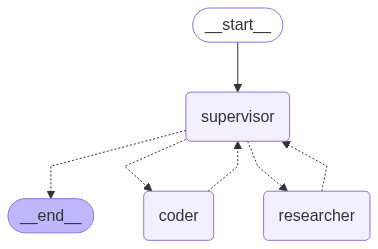

In [103]:
display(Image(app.get_graph().draw_mermaid_png()))

In [106]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************


NameError: name 'python_repl_tool' is not defined

In [ ]:
result=app.invoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)

**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
researcher
**********BELOW IS MY GOTO***************
coder


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}

In [104]:
result=app.ainvoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)

In [105]:
result

<coroutine object Pregel.ainvoke at 0x7fc12213d840>

# Summarized code